Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)


In [3]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    """
    Функция для оценки работы модели
    Parameters:
    train_true_values - целевая переменная из тренировочной части датасета
    train_pred_values - предсказания модели по тренировочной части
    val_true_values - целевая переменная из валидационной части датасета
    val_pred_values - предсказания модели по валидационной части
    Returns:
    R2 на тренировочной и валидационной части, 
    графики зависимости истинных значений от предсказаний
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=val_pred_values, y=val_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

Пути к файлам

In [4]:
TRAIN_DATASET_PATH = 'kaggle_data2/train.csv'
TEST_DATASET_PATH = 'kaggle_data2/test.csv'

Загрузка данных

Описание датасета

Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

In [46]:
train_df = pd.read_csv(TRAIN_DATASET_PATH).set_index('Id')
display(train_df.tail())
print(train_df.shape)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
77,32,2.00000,50.40178,30.47620,5.00000,6,5.00000,1968,0.13565,B,B,46,7960,6,350.00000,3,11,B,196684.31604
6159,18,1.00000,41.52155,20.53922,9.00000,13,13.00000,2000,0.00000,B,B,30,5562,0,nan,0,5,A,189050.28957
5123,27,1.00000,47.93901,nan,1.00000,12,16.00000,2015,0.07216,B,B,2,629,1,nan,0,0,A,159143.80537
5400,75,2.00000,43.60256,33.84015,8.00000,1,5.00000,1961,0.30747,B,A,30,5048,9,325.00000,2,5,B,181595.33981
6306,128,1.00000,38.66664,21.15787,8.00000,7,17.00000,1990,0.00000,B,B,27,4798,0,30.00000,2,8,B,218714.07762


(10000, 19)


In [47]:
train_idxs = list(train_df.index)

In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH).set_index('Id')
display(test_df.tail())
print(test_df.shape)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
8180,11,3.00000,67.13391,50.80980,6.00000,5,9.00000,1973,0.00017,B,B,36,5992,0,nan,1,1,B
4695,1,1.00000,40.19847,21.80706,10.00000,12,17.00000,2017,0.00712,B,B,1,264,0,nan,0,1,B
5783,12,3.00000,77.84218,48.28263,9.00000,23,22.00000,1989,0.09080,B,B,74,19083,2,nan,5,15,B
4780,62,2.00000,81.30522,nan,0.00000,4,0.00000,1977,0.07216,B,B,2,629,1,nan,0,0,A
12504,30,2.00000,60.55569,nan,1.00000,10,17.00000,1977,0.00008,B,B,22,6398,141,1046.00000,3,23,B


(5000, 18)


In [114]:
test_idxs = list(test_df.index)

Типы данных

In [48]:
train_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [49]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [50]:
train_df.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Количественные переменные

In [51]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.00000,1.89050,0.83951,0.00000,1.00000,2.00000,2.00000,19.00000
Square,10000.00000,56.31578,21.05873,1.13686,41.77488,52.51331,65.90063,641.06519
LifeSquare,7887.00000,37.19964,86.24121,0.37062,22.76983,32.78126,45.12880,7480.59213
KitchenSquare,10000.00000,6.27330,28.56092,0.00000,1.00000,6.00000,9.00000,2014.00000
Floor,10000.00000,8.52670,5.24115,1.00000,4.00000,7.00000,12.00000,42.00000
HouseFloor,10000.00000,12.60940,6.77597,0.00000,9.00000,13.00000,17.00000,117.00000
HouseYear,10000.00000,3990.16630,200500.26143,1910.00000,1974.00000,1977.00000,2001.00000,20052011.00000
Ecology_1,10000.00000,0.11886,0.11903,0.00000,0.01765,0.07542,0.19578,0.52187
Social_1,10000.00000,24.68700,17.53261,0.00000,6.00000,25.00000,36.00000,74.00000
Social_2,10000.00000,5352.15740,4006.79980,168.00000,1564.00000,5285.00000,7227.00000,19083.00000


Обработка выбросов

## Rooms

In [52]:
train_df['Rooms'].value_counts()

2.00000     3880
1.00000     3705
3.00000     2235
4.00000      150
5.00000       18
0.00000        8
10.00000       2
19.00000       1
6.00000        1
Name: Rooms, dtype: int64

In [53]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

In [54]:
train_df['Rooms'].value_counts()

2.00000    3891
1.00000    3705
3.00000    2235
4.00000     150
5.00000      18
6.00000       1
Name: Rooms, dtype: int64

In [8]:
test_df['Rooms'].value_counts()

2.00000     2030
1.00000     1769
3.00000     1099
4.00000       90
5.00000        7
0.00000        2
6.00000        2
17.00000       1
Name: Rooms, dtype: int64

In [9]:
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = test_df['Rooms'].median()

## Square, LifeSquare, KitchenSquare

In [55]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.00000,7887.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,5202.00000,10000.00000,10000.00000,10000.00000
mean,1.88880,56.31578,37.19964,6.27330,8.52670,12.60940,3990.16630,0.11886,24.68700,5352.15740,8.03920,1142.90446,1.31950,4.23130,214138.85740
std,0.81210,21.05873,86.24121,28.56092,5.24115,6.77597,200500.26143,0.11903,17.53261,4006.79980,23.83187,1021.51726,1.49360,4.80634,92872.29387
min,1.00000,1.13686,0.37062,0.00000,1.00000,0.00000,1910.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000,59174.77803
25%,1.00000,41.77488,22.76983,1.00000,4.00000,9.00000,1974.00000,0.01765,6.00000,1564.00000,0.00000,350.00000,0.00000,1.00000,153872.63394
50%,2.00000,52.51331,32.78126,6.00000,7.00000,13.00000,1977.00000,0.07542,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000,192269.64488
75%,2.00000,65.90063,45.12880,9.00000,12.00000,17.00000,2001.00000,0.19578,36.00000,7227.00000,5.00000,1548.00000,2.00000,6.00000,249135.46217
max,6.00000,641.06519,7480.59213,2014.00000,42.00000,117.00000,20052011.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000,633233.46657


In [56]:
train_df.loc[train_df['Square'] < 10, 'Square'] = np.nan

In [58]:
train_df.loc[train_df['LifeSquare'] < 10 , 'LifeSquare'] = np.nan
train_df.loc[train_df['LifeSquare'] > 640 , 'LifeSquare'] = np.nan

In [59]:
train_df.loc[train_df['KitchenSquare'] < 3 , 'KitchenSquare'] = np.nan
train_df.loc[train_df['KitchenSquare'] > 100 , 'KitchenSquare'] = np.nan

In [60]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

In [61]:
imputer = IterativeImputer(max_iter=1000)

In [62]:
imp_arr = pd.DataFrame(imputer.fit_transform(train_df.select_dtypes(exclude='object')))

In [63]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,9988.00000,7681.00000,6834.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,5202.00000,10000.00000,10000.00000,10000.00000
mean,1.88880,56.37899,37.13035,8.18466,8.52670,12.60940,3990.16630,0.11886,24.68700,5352.15740,8.03920,1142.90446,1.31950,4.23130,214138.85740
std,0.81210,20.99215,19.81312,4.05575,5.24115,6.77597,200500.26143,0.11903,17.53261,4006.79980,23.83187,1021.51726,1.49360,4.80634,92872.29387
min,1.00000,13.78486,10.52387,3.00000,1.00000,0.00000,1910.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000,59174.77803
25%,1.00000,41.78709,23.28171,6.00000,4.00000,9.00000,1974.00000,0.01765,6.00000,1564.00000,0.00000,350.00000,0.00000,1.00000,153872.63394
50%,2.00000,52.53991,33.10997,8.00000,7.00000,13.00000,1977.00000,0.07542,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000,192269.64488
75%,2.00000,65.92555,45.38116,10.00000,12.00000,17.00000,2001.00000,0.19578,36.00000,7227.00000,5.00000,1548.00000,2.00000,6.00000,249135.46217
max,6.00000,641.06519,638.16319,96.00000,42.00000,117.00000,20052011.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000,633233.46657


In [64]:
train_df.loc[train_df['Square'].isnull(), 'Square'] = train_df['Square'].median()

In [65]:
train_df.loc[train_df['KitchenSquare'].isnull(), 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [66]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()

In [12]:
test_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00000,5000.00000,5000.00000,3959.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,2623.00000,5000.00000,5000.00000
mean,51.27920,1.90780,56.44950,36.15881,5.97680,8.63200,12.60100,1984.39260,0.11987,24.93380,5406.90000,8.26260,1146.65726,1.31940,4.24280
std,44.17947,0.81008,19.09279,17.82529,9.95002,5.48323,6.78921,18.57315,0.12007,17.53220,4026.61477,23.86376,1044.74423,1.47994,4.77736
min,0.00000,1.00000,1.37854,0.33349,0.00000,1.00000,0.00000,1908.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000
25%,21.00000,1.00000,41.90623,23.09203,1.00000,4.00000,9.00000,1973.00000,0.01951,6.00000,1564.00000,0.00000,325.00000,0.00000,1.00000
50%,37.00000,2.00000,52.92134,32.92509,6.00000,7.00000,12.00000,1977.00000,0.07216,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000
75%,77.00000,2.00000,66.28513,45.17409,9.00000,12.00000,17.00000,2000.00000,0.19578,36.00000,7287.00000,5.00000,1548.00000,2.00000,6.00000
max,212.00000,6.00000,223.45369,303.07109,620.00000,78.00000,99.00000,2020.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000


In [13]:
test_df.loc[test_df['Square'] < 10, 'Square'] = np.nan

In [14]:
test_df.loc[test_df['LifeSquare'] < 10 , 'LifeSquare'] = np.nan
test_df.loc[test_df['LifeSquare'] > 220 , 'LifeSquare'] = np.nan

In [15]:
test_df.loc[test_df['KitchenSquare'] < 3 , 'KitchenSquare'] = np.nan
test_df.loc[test_df['KitchenSquare'] > 80 , 'KitchenSquare'] = np.nan

In [18]:
imp_arr = pd.DataFrame(imputer.fit_transform(test_df.select_dtypes(exclude='object')))

In [19]:
test_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00000,5000.00000,4992.00000,3848.00000,3467.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,2623.00000,5000.00000,5000.00000
mean,51.27920,1.90780,56.53456,37.02529,8.03461,8.63200,12.60100,1984.39260,0.11987,24.93380,5406.90000,8.26260,1146.65726,1.31940,4.24280
std,44.17947,0.81008,18.98927,16.64062,3.48742,5.48323,6.78921,18.57315,0.12007,17.53220,4026.61477,23.86376,1044.74423,1.47994,4.77736
min,0.00000,1.00000,13.30553,10.69250,3.00000,1.00000,0.00000,1908.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000
25%,21.00000,1.00000,41.92753,23.65326,6.00000,4.00000,9.00000,1973.00000,0.01951,6.00000,1564.00000,0.00000,325.00000,0.00000,1.00000
50%,37.00000,2.00000,52.95776,33.24449,8.00000,7.00000,12.00000,1977.00000,0.07216,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000
75%,77.00000,2.00000,66.29563,45.54433,10.00000,12.00000,17.00000,2000.00000,0.19578,36.00000,7287.00000,5.00000,1548.00000,2.00000,6.00000
max,212.00000,6.00000,223.45369,169.90170,65.00000,78.00000,99.00000,2020.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000


In [23]:
test_df.loc[test_df['Square'].isnull(), 'Square'] = test_df['Square'].median()

In [24]:
test_df.loc[test_df['KitchenSquare'].isnull(), 'KitchenSquare'] = test_df['KitchenSquare'].median()

In [25]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = test_df['LifeSquare'].median()

## HouseFloor, Floor

In [67]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [68]:
train_df['HouseFloor'].sort_values().unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  36.,
        37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [69]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [70]:
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [71]:
display(train_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00000,47.98156,29.44275,6.00000,7,9.00000,1969,0.08904,B,B,33,7976,5,nan,0,11,B,184966.93073
15053,41,3.00000,65.68364,40.04954,8.00000,7,9.00000,1978,0.00007,B,B,46,10309,1,240.00000,1,16,B,300009.45006
4765,53,2.00000,44.94795,29.19761,8.00000,8,12.00000,1968,0.04964,B,B,34,7759,0,229.00000,1,3,B,220925.90852
5809,58,2.00000,53.35298,52.73151,9.00000,8,17.00000,1977,0.43789,B,B,23,5735,3,1084.00000,0,5,B,175616.22722
10783,99,1.00000,39.64919,23.77617,7.00000,11,12.00000,1976,0.01234,B,B,35,5776,1,2078.00000,2,4,B,150226.53164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.00000,50.40178,30.47620,5.00000,4,5.00000,1968,0.13565,B,B,46,7960,6,350.00000,3,11,B,196684.31604
6159,18,1.00000,41.52155,20.53922,9.00000,13,13.00000,2000,0.00000,B,B,30,5562,0,nan,0,5,A,189050.28957
5123,27,1.00000,47.93901,33.10997,8.00000,12,16.00000,2015,0.07216,B,B,2,629,1,nan,0,0,A,159143.80537


In [30]:
test_df['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.])

In [32]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

In [33]:
test_df['HouseFloor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40., 48.,
       99.])

In [34]:
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78], dtype=int64)

In [35]:
floor_outliers = test_df[test_df['Floor'] > test_df['HouseFloor']].index

test_df.loc[floor_outliers, 'Floor'] = test_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

## HouseYear

In [72]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [73]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = train_df['HouseYear'].median()

In [74]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = train_df['HouseYear'].median()

In [75]:
train_df['HouseYear'].sort_values().unique()

array([1910., 1912., 1914., 1916., 1917., 1918., 1919., 1928., 1929.,
       1930., 1931., 1932., 1933., 1934., 1935., 1936., 1937., 1938.,
       1939., 1940., 1941., 1942., 1947., 1948., 1950., 1951., 1952.,
       1953., 1954., 1955., 1956., 1957., 1958., 1959., 1960., 1961.,
       1962., 1963., 1964., 1965., 1966., 1967., 1968., 1969., 1970.,
       1971., 1972., 1973., 1974., 1975., 1976., 1977., 1978., 1979.,
       1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016., 2017., 2018., 2019., 2020.])

In [76]:
train_df[['HouseYear']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   HouseYear  10000 non-null  float64
dtypes: float64(1)
memory usage: 476.2 KB


In [77]:
train_df['HouseYear'] = train_df['HouseYear'].astype(int)

In [78]:
train_df[['HouseYear']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   HouseYear  10000 non-null  int32
dtypes: int32(1)
memory usage: 437.2 KB


In [79]:
train_df['HouseYear'].sort_values().unique()

array([1910, 1912, 1914, 1916, 1917, 1918, 1919, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1947, 1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [36]:
test_df['HouseYear'].sort_values().unique()

array([1908, 1909, 1910, 1911, 1912, 1914, 1917, 1918, 1920, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1937, 1938, 1939,
       1940, 1941, 1943, 1948, 1949, 1950, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

# Healthcare_1

In [80]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [37]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

# Категориальные признаки

In [81]:
train_df['Ecology_2'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [38]:
test_df['Ecology_2'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [41]:
test_df['Shops_2'].sort_values().unique()

array([0, 1], dtype=int64)

# Новые признаки


In [82]:
med_price_by_district = train_df.groupby(['DistrictId', 'Healthcare_1'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Healthcare_1,MedPriceByDistrict
0,0,645.00000,162985.11657
1,0,2857.00000,173146.32397
2,1,200.00000,145304.77355
3,1,240.00000,203858.09575
4,1,900.00000,183136.34042


In [83]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Healthcare_1'], how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
0,35,2.00000,47.98156,29.44275,6.00000,7,9.00000,1969,0.08904,1,1,33,7976,5,900.00000,0,11,1,184966.93073,203602.40890
1,41,3.00000,65.68364,40.04954,8.00000,7,9.00000,1978,0.00007,1,1,46,10309,1,240.00000,1,16,1,300009.45006,172138.91352
2,53,2.00000,44.94795,29.19761,8.00000,8,12.00000,1968,0.04964,1,1,34,7759,0,229.00000,1,3,1,220925.90852,255009.42367
3,58,2.00000,53.35298,52.73151,9.00000,8,17.00000,1977,0.43789,1,1,23,5735,3,1084.00000,0,5,1,175616.22722,132736.17864
4,99,1.00000,39.64919,23.77617,7.00000,11,12.00000,1976,0.01234,1,1,35,5776,1,2078.00000,2,4,1,150226.53164,186983.02159


In [84]:
train_df['MedPriceByDistrict'].isnull().sum()

0

переноса признака на test

In [85]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [86]:
test_df.merge(med_price_by_district, on=['DistrictId', 'Healthcare_1'], how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DistrictId          5000 non-null   object 
 1   Rooms               5000 non-null   float64
 2   Square              5000 non-null   float64
 3   LifeSquare          5000 non-null   float64
 4   KitchenSquare       5000 non-null   float64
 5   Floor               5000 non-null   int64  
 6   HouseFloor          5000 non-null   float64
 7   HouseYear           5000 non-null   int64  
 8   Ecology_1           5000 non-null   float64
 9   Ecology_2           5000 non-null   int64  
 10  Ecology_3           5000 non-null   int64  
 11  Social_1            5000 non-null   int64  
 12  Social_2            5000 non-null   int64  
 13  Social_3            5000 non-null   int64  
 14  Healthcare_1        5000 non-null   float64
 15  Helthcare_2         5000 non-null   int64  
 16  Shops_

# Отбор признаков


In [87]:
train_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'MedPriceByDistrict']

In [88]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['MedPriceByDistrict']

target_name = 'Price'

In [90]:
test_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

# Разбивка на train и val

In [91]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [92]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [93]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict
9185,1.00000,39.83774,23.28137,7.00000,13,17.00000,2010,0.00766,1,1,35,7077,56,2301.00000,3,19,1,310891.02405
6945,2.00000,17.41418,33.10997,8.00000,4,20.00000,1977,0.07216,1,1,2,629,1,900.00000,0,0,0,159825.82390
6615,1.00000,44.84656,21.58987,8.00000,3,14.00000,2004,0.00000,1,1,36,6714,2,2672.00000,0,2,1,214370.71953
9527,2.00000,52.44986,27.14581,7.00000,3,5.00000,1953,0.16909,1,1,19,3856,10,900.00000,2,5,1,301210.09090
4336,3.00000,65.52154,39.97374,8.00000,5,9.00000,1976,0.16909,1,1,19,3856,10,900.00000,2,5,1,301210.09090


# Модель

Обучение и оценка


In [94]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

Train R2:	0.964
Valid R2:	0.729


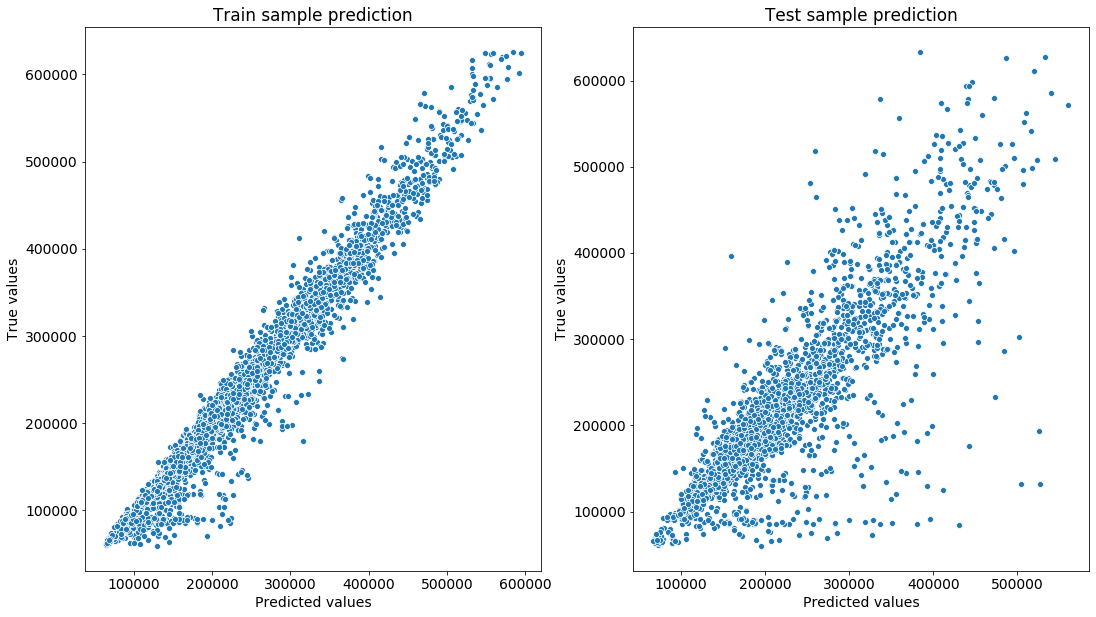

In [95]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_val)

evaluate_preds(y_train, y_train_preds, y_val, y_test_preds)

# Перекрестна проверка

In [96]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.74859412, 0.70117903, 0.73545435, 0.76317542, 0.74208362])

In [97]:
cv_score.mean()

0.738097308026884

# Важность признаков

In [98]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.41725
17,MedPriceByDistrict,0.32251
0,Rooms,0.03254
6,HouseYear,0.03122
2,LifeSquare,0.03103
12,Social_3,0.02688
5,HouseFloor,0.02092
4,Floor,0.02013
11,Social_2,0.01887
3,KitchenSquare,0.01763


In [99]:
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.00000,49.88264,33.43278,6.00000,6,14.00000,1972,0.31020,1,1,11,2748,1,900.00000,0,0,1
15856,74,2.00000,69.26318,33.24449,8.00000,1,1.00000,1977,0.07578,1,1,6,1437,3,900.00000,0,2,1
5480,190,1.00000,13.59782,15.94825,12.00000,2,5.00000,1909,0.00000,1,1,30,7538,87,4702.00000,5,5,1
15664,47,2.00000,73.04661,51.94084,9.00000,22,22.00000,2007,0.10187,1,1,23,4583,3,900.00000,3,3,1
14275,27,1.00000,47.52711,43.38757,8.00000,17,17.00000,2017,0.07216,1,1,2,629,1,900.00000,0,0,0


In [101]:
x_test_preds = rf_model.predict(test_df)

# Сохранение результата в файл

In [119]:
output=pd.DataFrame(data={'Id':test_idxs,'Price':x_test_preds}) 
output.to_csv(path_or_buf="VEBelokobylskaya_predictions.csv",index=False,quoting=3,sep=';')